# Creazione modelli per previsione SQUAT
> Decision TreeClassifier

> Logistic Regression 

> Regressione lineare multivariata

In [1140]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn import tree
from matplotlib import pyplot as plt
import seaborn as sns
import os

In [1141]:
max_lunghezza_albero = 5
potatura = 0.005

shift = 1
rolling_periods = 3

## Import dati

In [1142]:
# df_raw = pd.read_csv('/Users/lorenzobassetti/Dropbox/Quant/Python_DEV/artabax/squat_1205_1.csv' , sep=';' , decimal='.')
# df_raw.set_index('Time', inplace=True)
# df_raw.drop(columns='prob', inplace=True)
# df

In [1143]:
path = '/Users/lorenzobassetti/Dropbox/Quant/Python_DEV/'
# df1 = pd.read_csv('/Users/lorenzobassetti/Dropbox/Quant/Python_DEV/artabax/squat_1130_1.csv' , sep=';' , decimal='.')
df2 = pd.read_csv(path+'artabax/data_modelli/sq_bax_1207_1.csv' , sep=';' , decimal='.')
df3 = pd.read_csv(path+'artabax/data_modelli/sq_bax_1207_2.csv' , sep=';' , decimal='.')
df4 = pd.read_csv(path+'artabax/data_modelli/sq_paolo_1207_1.csv' , sep=';' , decimal='.')
df5 = pd.read_csv(path+'artabax/data_modelli/sq_paolo_1207_2.csv' , sep=';' , decimal='.')
df_raw = pd.concat([
                    df2,
                    df3,
                    df4,
                    df5,
                    ], axis=0, ignore_index=True).drop(columns=[
                        'prob',
                        'Time',
                        # 'Mag',
                        ])
df_raw.reset_index(drop=True, inplace=True)
bar_zero = df_raw['BAR'][0]
df_raw['BAR'] = (df_raw['BAR']/bar_zero)
# df_raw.set_index('Time', inplace=True)
df_raw

,Ax,Ay,Az,Gx,Gy,Gz,BAR,P,R,UP,DOWN
0,10.14291,-0.78796,4.04758,6.16000,2.17000,-5.18000,1.000000,0,0,0,0
1,8.75859,-1.01070,3.54223,26.66999,3.08000,-2.87000,1.000003,0,0,0,0
2,9.34297,-0.91250,2.89558,29.39999,0.84000,13.30000,0.999990,0,0,0,0
3,10.34649,0.14610,2.75906,38.98999,13.92999,20.78999,0.999996,0,0,0,0
4,10.66263,1.52563,3.32429,21.62999,-1.19000,1.47000,0.999979,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2366,9.88904,-0.56522,1.92320,-0.77000,5.81000,0.28000,1.000015,0,0,1,0
2367,10.12375,-0.55325,2.37586,-2.10000,-2.59000,-0.70000,0.999996,0,0,1,0
2368,10.33451,-0.70414,2.45490,0.56000,1.12000,-2.59000,1.000002,0,0,1,0
2369,10.51653,-0.36883,1.54958,1.47000,3.57000,-12.11000,1.000022,0,0,1,0


In [1144]:
df = df_raw.copy()

# df_temp = df.loc[df['DOWN'] ==1]
# pos = np.array(df_temp.index)
# for i in pos:
#     for k in range(-shift+1, shift, 1):
#         df.at[i+k, 'DOWN'] =1

# df = df[df.columns.difference(['prob'])].rolling(3).mean()
# df['Ax'] = df['Ax'].rolling(rolling_periods).mean()
# df['Ay'] = df['Ay'].rolling(rolling_periods).mean()
# df['Az'] = df['Az'].rolling(rolling_periods).mean()
# df['BAR'] = df['BAR'].rolling(rolling_periods).mean()
# df['Gx'] = df['Gx'].rolling(rolling_periods).mean()
# df['Gy'] = df['Gy'].rolling(rolling_periods).mean()
# df['Gz'] = df['Gz'].rolling(rolling_periods).mean()

df.dropna(inplace=True)

In [1145]:
df

,Ax,Ay,Az,Gx,Gy,Gz,BAR,P,R,UP,DOWN
0,10.14291,-0.78796,4.04758,6.16000,2.17000,-5.18000,1.000000,0,0,0,0
1,8.75859,-1.01070,3.54223,26.66999,3.08000,-2.87000,1.000003,0,0,0,0
2,9.34297,-0.91250,2.89558,29.39999,0.84000,13.30000,0.999990,0,0,0,0
3,10.34649,0.14610,2.75906,38.98999,13.92999,20.78999,0.999996,0,0,0,0
4,10.66263,1.52563,3.32429,21.62999,-1.19000,1.47000,0.999979,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2366,9.88904,-0.56522,1.92320,-0.77000,5.81000,0.28000,1.000015,0,0,1,0
2367,10.12375,-0.55325,2.37586,-2.10000,-2.59000,-0.70000,0.999996,0,0,1,0
2368,10.33451,-0.70414,2.45490,0.56000,1.12000,-2.59000,1.000002,0,0,1,0
2369,10.51653,-0.36883,1.54958,1.47000,3.57000,-12.11000,1.000022,0,0,1,0


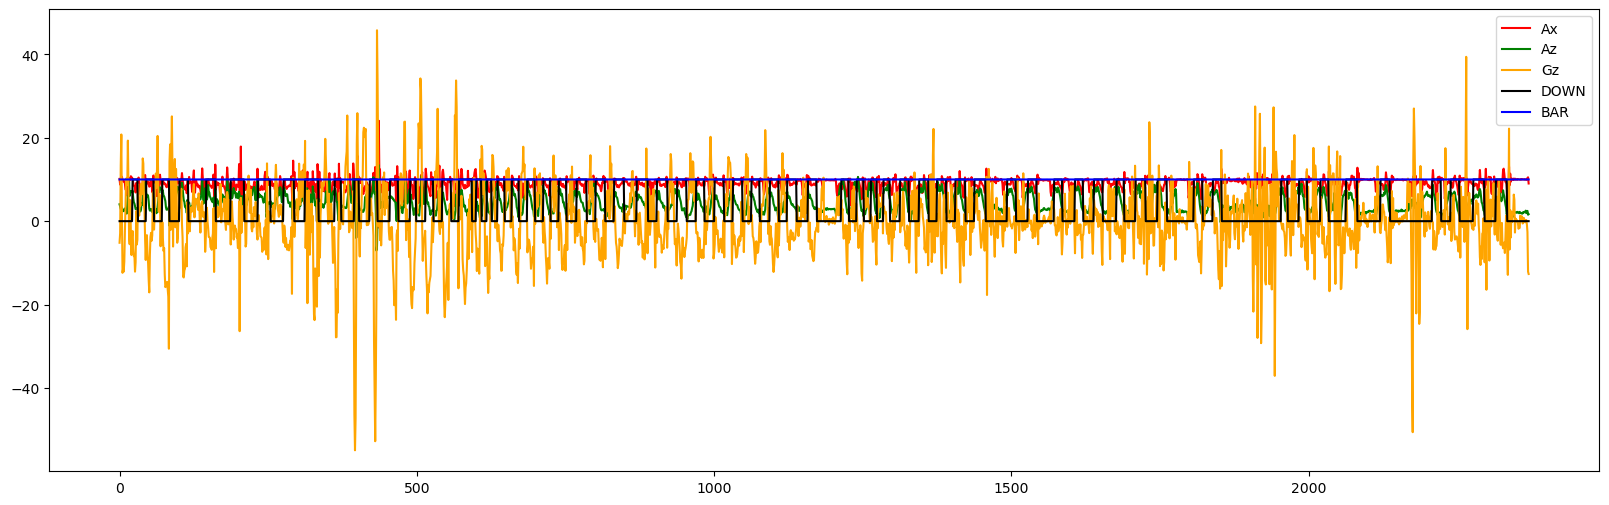

In [1146]:
plt.figure(figsize=(20,6))
plt.plot(df['Ax'], color='red', label='Ax')
# plt.plot(df['Ay'], color='blue', label='Ay')
plt.plot(df['Az'], color='green', label='Az')
plt.plot(df['Gz'], color='orange', label='Gz')
plt.plot(df['DOWN']*10, color='black', label='DOWN')
plt.plot(df['BAR']*10, color='blue', label='BAR')
plt.legend()
plt.show()

## Preparazione datasets

In [1147]:
## Y è l'output che utilizziamo come training
## X sono le feautures, BISOGNA togliere la Y dalle colonne feautures 
y = df['DOWN']
X = df.copy()
X.drop(columns=['DOWN','UP'], axis=1, inplace=True)

##Divido il campione in Train e Test
X_train, X_test , y_train , y_test = train_test_split(X, y, test_size=0.2, random_state=None)

# Modelli

## DecisionTree Classifier

Accuracy:   0.853
Precision:  0.796
Recall:     0.787


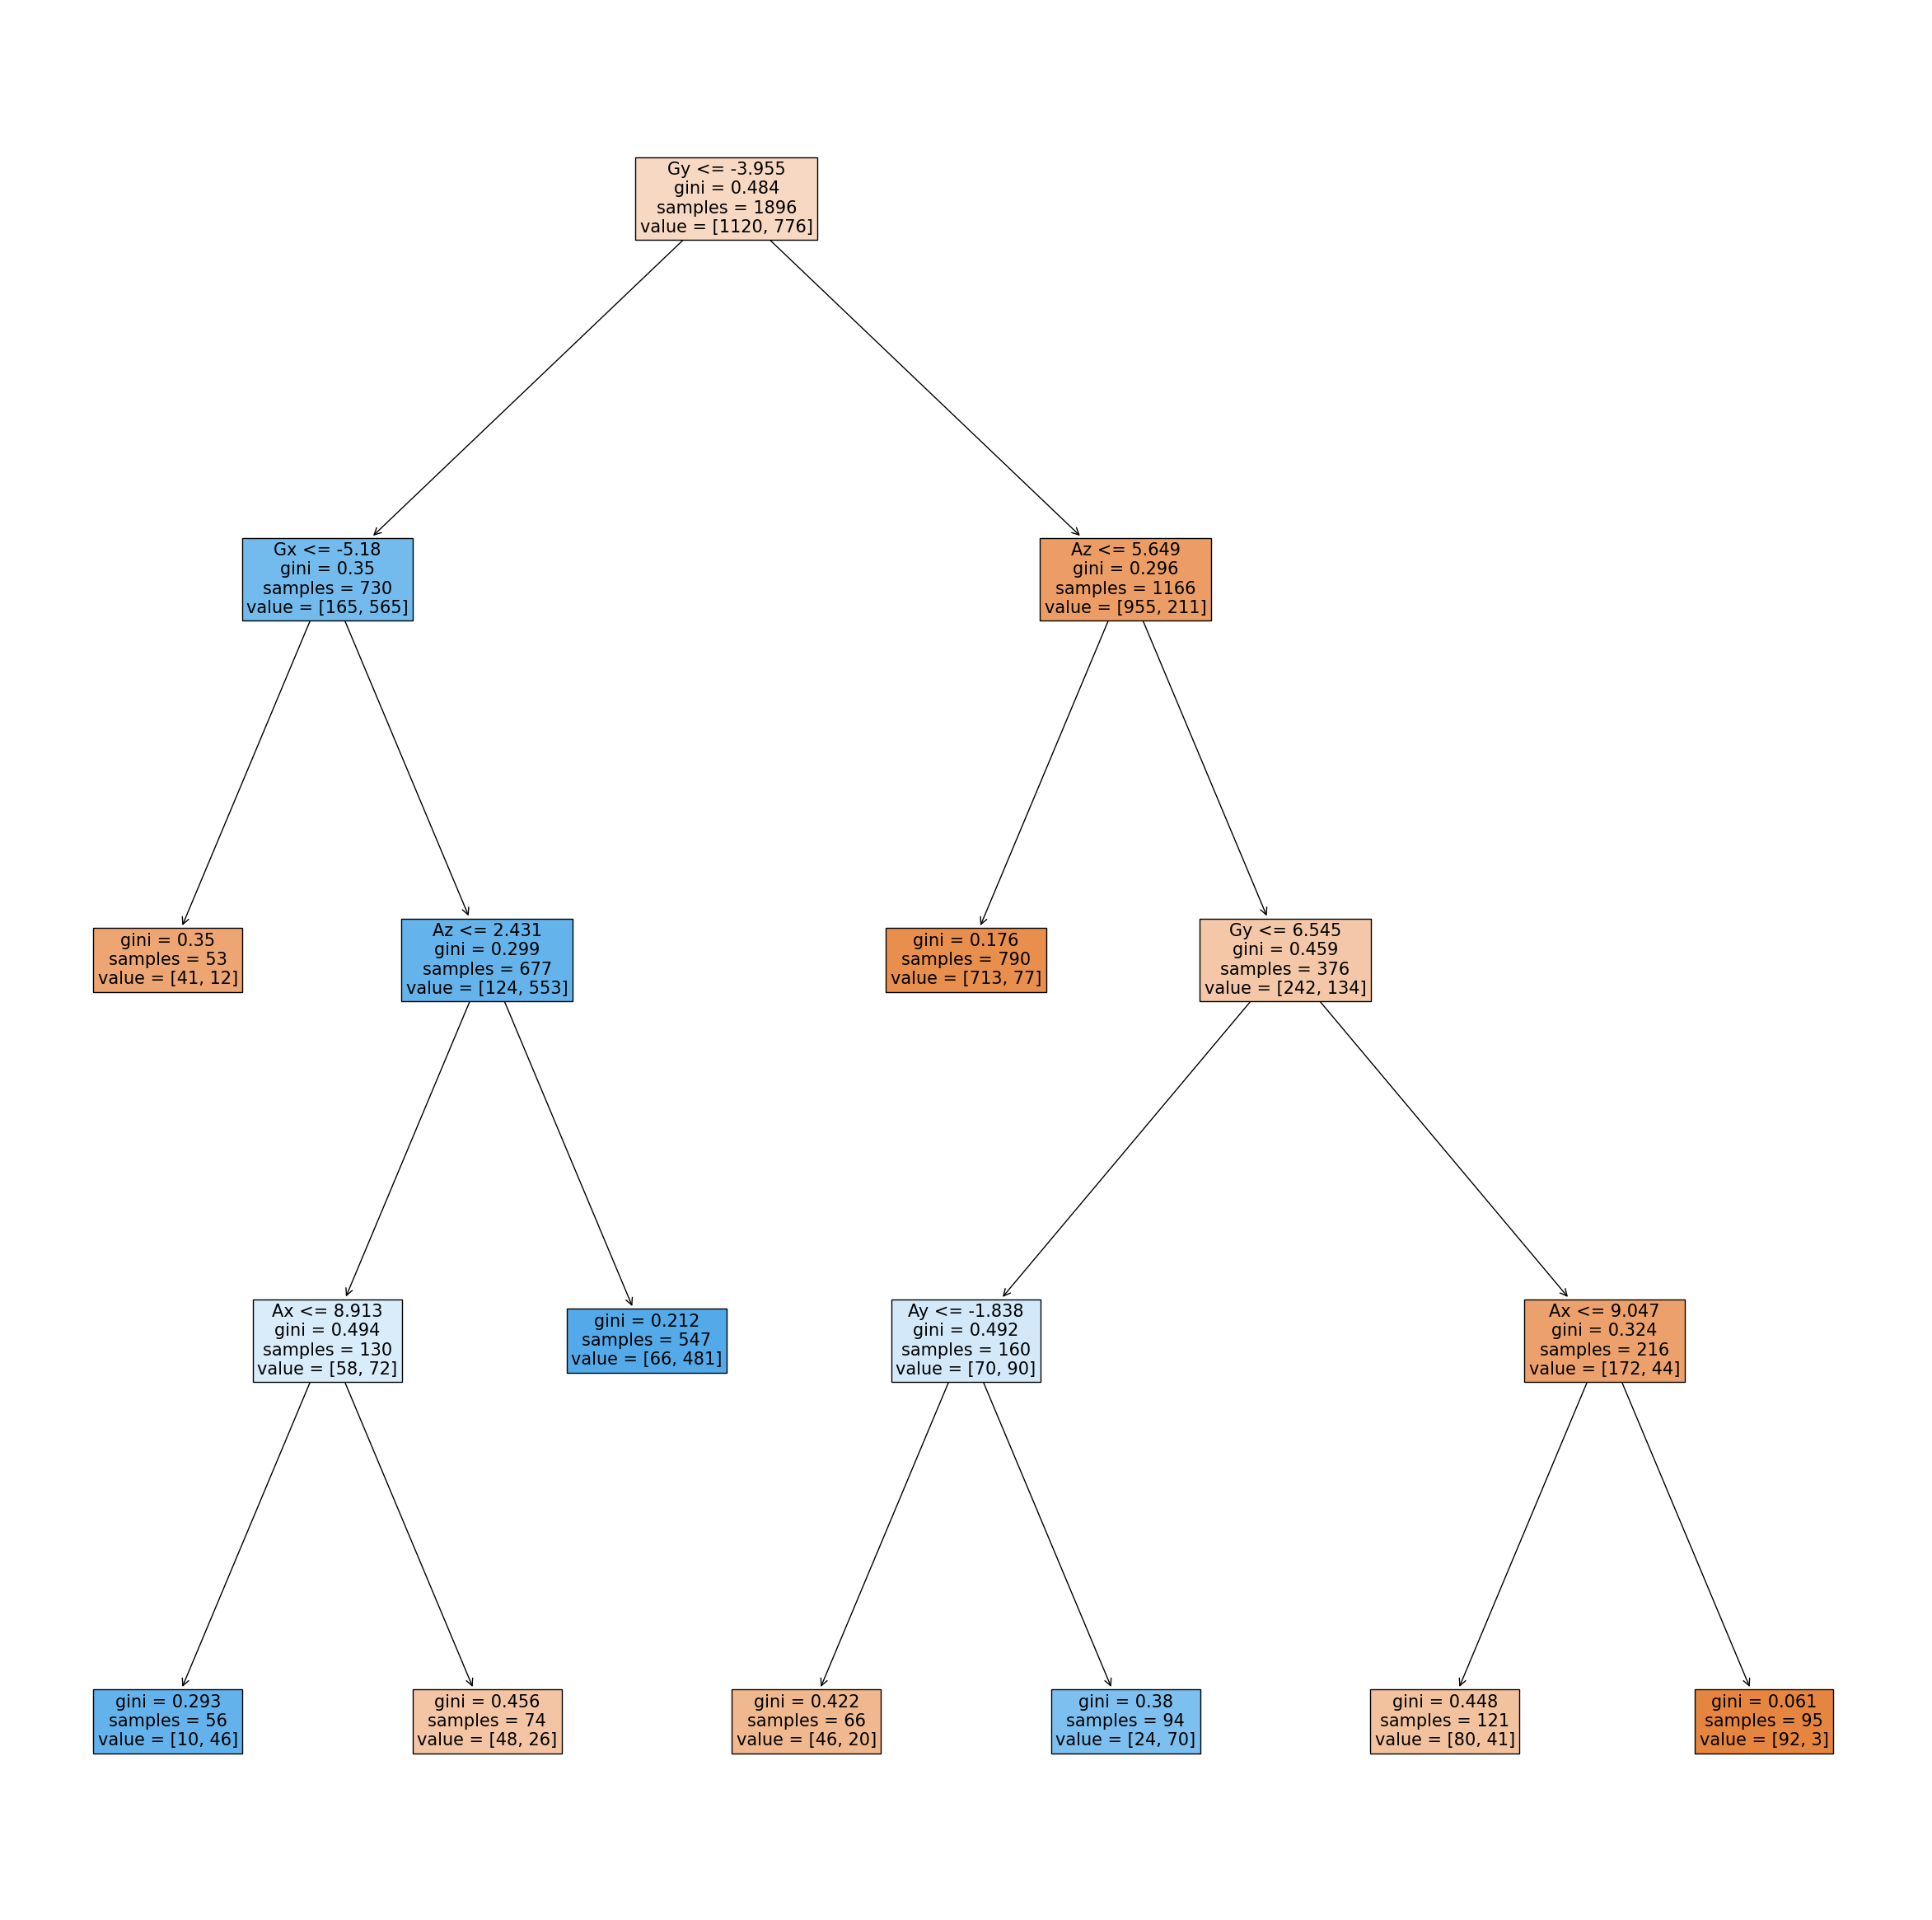

In [1148]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=max_lunghezza_albero , ccp_alpha=potatura)
clf = clf.fit(X_train, y_train)
param = clf.get_params()
predictions = clf.predict(X_test)
accuracy = clf.score(X_train, y_train)
precision = precision_score(y_true= y_test, y_pred=predictions)
recall = recall_score(y_true= y_test, y_pred=predictions)

print('Accuracy:  ', round(accuracy,3))
print('Precision: ', round(precision,3))
print('Recall:    ', round(recall,3))

from sklearn import tree
feature_names = X.columns
fig = plt.figure(figsize=(30,30))
_= tree.plot_tree(clf, 
        feature_names=feature_names, 
        filled=True, fontsize=15)


In [1149]:
##importanza features
feature_names = X.columns
feature_importance = pd.DataFrame(clf.feature_importances_, index=feature_names).sort_values(0, ascending=False)

print(feature_importance.head(10))
important_features = list(feature_importance[feature_importance[0]>0].index)
# feature_importance.head(10).plot(kind='bar')

            0
Gy   0.723144
Az   0.120190
Gx   0.073012
Ax   0.051425
Ay   0.032228
Gz   0.000000
BAR  0.000000
P    0.000000
R    0.000000


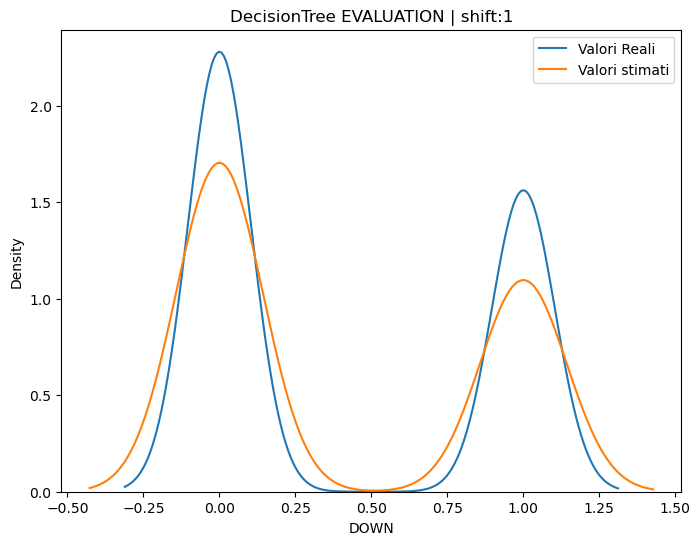

In [1150]:
plt.figure(figsize=(8, 6))
plt.title('DecisionTree EVALUATION' +' | shift:'+str(shift))
sns.kdeplot(data=df, x='DOWN' , label='Valori Reali')
sns.kdeplot(predictions , label='Valori stimati')
plt.legend()
plt.show()

## Logistic Regression

In [1151]:
log_reg = LogisticRegression(random_state=None, solver = 'lbfgs', max_iter=1000)
log_reg.fit(X_train, y_train)

# predict - Predict class labels for samples in X
y_pred = log_reg.predict(X_train)

# coef_ - Coefficient of the features in the decision function
log_reg.coef_

lr = pd.DataFrame(data =[X_train.columns, np.array(log_reg.coef_[0]).tolist()]).T
lr.rename(columns={0:'Reg',1:'Logistic'}, inplace=True)
lr.set_index('Reg', inplace=True)
lr.sort_values(by='Logistic', key=abs, ascending=False , inplace=True)
print(lr)
print('b0:',log_reg.intercept_[0])

     Logistic
Reg          
Az   0.490371
Ax  -0.343194
Ay   0.260042
Gy  -0.090574
Gx   0.050916
Gz  -0.009048
BAR  0.002777
P         0.0
R         0.0
b0: 0.5329237223200488


LogReg Training Accuracy is:  0.8280590717299579
LogReg Testing Accuracy is:  0.8273684210526315


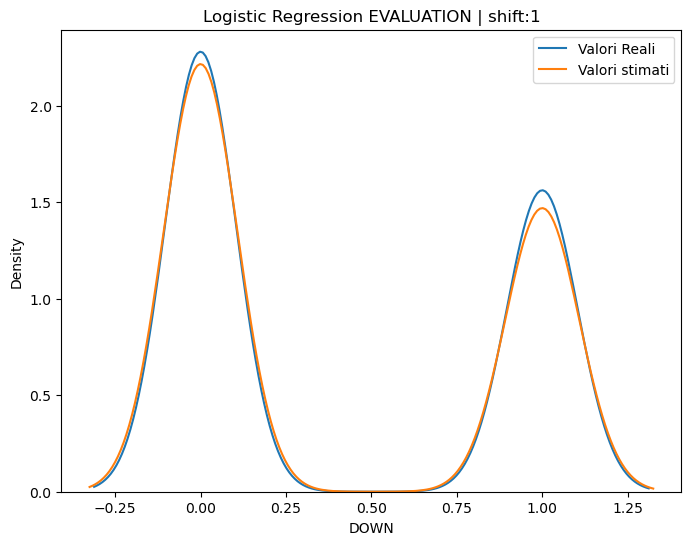

In [1152]:
'''Logistic Regression EVALUATION'''

# Accuracy on Train
print("LogReg Training Accuracy is: ", log_reg.score(X_train, y_train))
# Accuracy on Test
print("LogReg Testing Accuracy is: ", log_reg.score(X_test, y_test))
# Classification Report

plt.figure(figsize=(8, 6))
plt.title('Logistic Regression EVALUATION' +' | shift:'+str(shift))
sns.kdeplot(data=df, x='DOWN' , label='Valori Reali')
sns.kdeplot(y_pred , label='Valori stimati')
plt.legend()
plt.show()


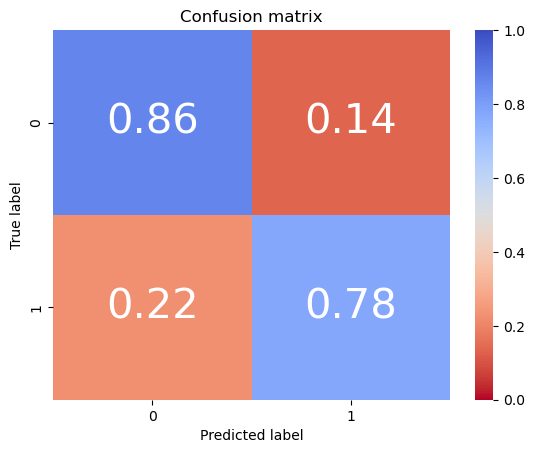

In [1153]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, cmap="coolwarm_r", 
                    xticklabels=classes, 
                    yticklabels=classes, 
                    vmin=0., vmax=1., 
                    annot=True, annot_kws={'size':30}
                    )
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Visualizing cm

cm = confusion_matrix(y_train, y_pred)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

plot_confusion_matrix(cm_norm, classes = log_reg.classes_, title='Confusion matrix')

In [1154]:
# Calculating False Positives (FP), False Negatives (FN), True Positives (TP) & True Negatives (TN)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP / (TP + FN)
print("The True Positive Rate is:", TPR)

# Precision or positive predictive value
PPV = TP / (TP + FP)
print("The Precision is:", PPV)

# False positive rate or False alarm rate
FPR = FP / (FP + TN)
print("The False positive rate is:", FPR)


# False negative rate or Miss Rate
FNR = FN / (FN + TP)
print("The False Negative Rate is: ", FNR)

The True Positive Rate is: [0.86339286 0.77706186]
The Precision is: [0.84824561 0.79761905]
The False positive rate is: [0.22293814 0.13660714]
The False Negative Rate is:  [0.13660714 0.22293814]


## Regressione Lineare Multivariata

            RLM
Reg            
BAR  784.860606
Az     0.067795
Ax     -0.05733
Ay     0.039029
Gy    -0.011274
Gx     0.006705
Gz    -0.001651
P           0.0
R           0.0
Termine noto: -784.2685139591645
 
Precisione:  0.4287301398862031


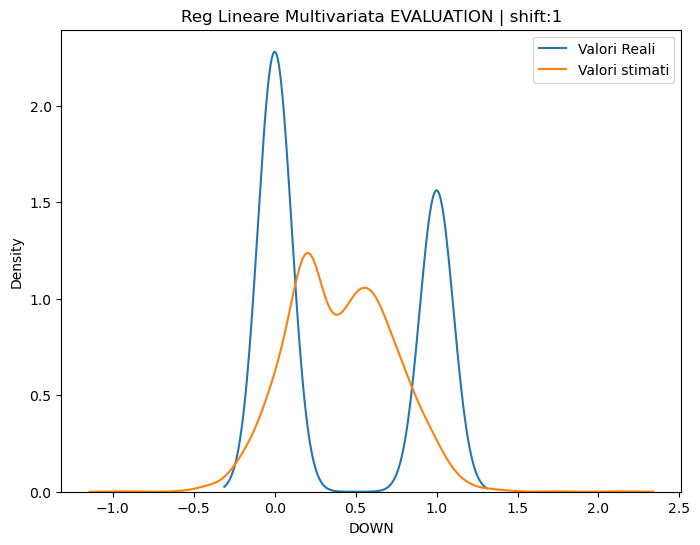

In [1155]:
mlr = LinearRegression()
y = df['DOWN']
X = df.copy()
X.drop(columns=['DOWN','UP'], axis=1, inplace=True)

mlr.fit(X, y)
Y_hat = mlr.predict(X)
b0 = mlr.coef_
b1 = mlr.intercept_

reg = pd.DataFrame(data =[X.columns, b0]).T
reg.rename(columns={0:'Reg',1:'RLM'}, inplace=True)
reg.set_index('Reg', inplace=True)
reg.sort_values(by='RLM', key=abs, ascending=False , inplace=True)

print(reg)
print('Termine noto:',b1)
print(' ')
print('Precisione: ', mlr.score(X, y))

plt.figure(figsize=(8, 6))
plt.title('Reg Lineare Multivariata EVALUATION' +' | shift:'+str(shift))
sns.kdeplot(data=df, x='DOWN' , label='Valori Reali')
sns.kdeplot(Y_hat , label='Valori stimati')
plt.legend()
plt.show()
